## In this project, you will implement a simple convolutional neural network that can recognize digits using [PyTorch](https://pytorch.org/)

### We will do the following steps in order:
1. Load the MNIST training and test datasets
2. Define a convolutional neural network (TODO)
3. Define a loss function and optimizer (TODO)
4. Train the network on the training data (TODO)
5. Test the network on the test data (TODO)

In section 2-5, you have to fill in the blanks with code. You should be figure out the solution by looking at the tutorial we provide

### Step 0: Importing Required Packages

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
# First off, import some packages
import torch
import torch.nn as nn
from torch.nn import functional as F

from torchvision import datasets, transforms
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import helper as h

In [3]:
# Seed the random number generator
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# Check whether you have a gpu
# If you have a gpu, model training will be done on gpu
# which is significantly faster than training on cpu
gpu_available = torch.cuda.is_available()

### Step 1:  Loading the Dataset and Setting up Dataloader

In [4]:
# Setup the training set and test set
trainset = datasets.MNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

# Setting up dataloader
# A dataloader stacks small batches (128 in our case) of dataset 
# into Tensor for ease of training.
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, drop_last=True, batch_size=128)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, drop_last=False, batch_size=128)

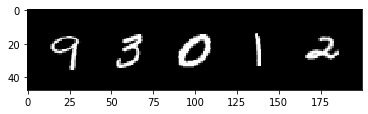

In [5]:
# Visualize the data
# The following line gets us small batch of data
# X is a tensor of size (128, 1, 28, 28) that contains
# a batch of images
# y is a tensor of size (128) that contains the labels  
# in X
X, y = iter(trainloader).next()

def visualize_data(X):
    img_grid = torchvision.utils.make_grid(X[:5], padding=10)
    img_grid = img_grid.numpy()
    plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation='nearest')
    return

visualize_data(X)

### Step 2: Define a convolutional neural network
#### Step 2.1: Define a building block of a convolutional neural network

In [6]:
class Block(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1):
        super(Block, self).__init__()
        
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.kernel_size = kernel_size
        self.stride = stride
        
        # This block contains a convolutional layer
        # then a batch normalization layer
        
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size, stride)
        self.bn = nn.BatchNorm2d(out_channel)
        return
    
    def forward(self, x):
        # passes the input image through a convolutional layer
        # followed by a batch normalization layer and relu transition
        out = F.relu(self.bn(self.conv(x)))
        return out

In [7]:
# Create a block that is made up of 10 filters size 3x3 and stride 1

# The block takes in a image of 1 channel
Block1 = Block(1, 10, 3, 1)
out = Block1(X)

# After passing our image through block 1
# we get the following tensor
print(out.shape)

torch.Size([128, 10, 26, 26])


#### Step 2.2: Building a convolutional neural network using the block class
In this section, you will build a convolutional network that consists of 4 blocks, an average pooling layer and a fully connected layer. We have created the first block for you. What you need to do is create the rest of the blocks based on the specification. Please do not change the name of the layers or else you risk breaking the autograder code!

In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__() 
        # First block takes in the image
        # Filter specification:
            # Num filters=16, kernel size 3, stride 1
        self.block1 = Block(1, 16, 3, 1)
        
        # TODO
        # Second block takes in the output of the first block
        # Filter specification:
            # Num filters=32, kernel size 3, stride 1
        self.block2 = None
        
        # TODO
        # Third block takes in the output of the 2nd block
        # Filter specification:
            # Num filters=64, kernel size 3, stride 1
        self.block3 = None
        
        # TODO
        # Third block takes in the output of the 3rd block
        # Filter specification:
            # Num filters=128, kernel size 3, stride 1
        self.block4 = None
        
        # This is the average pooling layer
        # This is applied to the output of the last convolutional layer
        # Essentially, it averages feature maps spatially to a single number
        # For instance, if the output of the last conv layer is of size (128, 15, 4, 4)
        # the following layer will average the 4x4 array into a single number
        # so the output of applying this layer would have size (128, 15, 1, 1)
        # This operation vectorize the feature maps so that we can have a vector
        # that can be passed into a simple linear layer for classification
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        # Create a linear layer
        # the dataset has 10 classes
        # the model should output 10 belief values
        self.fc = nn.Linear(128, 10)
        
        # BEGIN SOLUTION
        self.block2 = Block(16, 32, 3, 1)
        self.block3 = Block(32, 64, 3, 1)
        self.block4 = Block(64, 128, 3, 1)
        # END SOLUTION
        return
    
    def forward(self, x):
        batch_size = x.size(0)
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        
        # .squeeze() operation remove unnecessary dimension
        # i.e if X is of shape (128, 128, 1, 1)
        # X.unsqueeze() becomes (128, 128)
        out = self.avgpool(out).squeeze()
        out = self.fc(out)
        return out

In [9]:
# Create a model
model = ConvNet()

# Move the model to a cuda gpu
# Doing this step allows up to do training on gpu
# and gain significant speed up
if gpu_available:
    model = model.cuda()

In [10]:
def model_test1():
    
    model = ConvNet()
    
    if gpu_available:
        model = model.cuda()
    # check whether block2, 3, 4 are instances of block
    isblock2 = isinstance(model.block2, Block)
    isblock3 = isinstance(model.block3, Block)
    isblock4 = isinstance(model.block3, Block)
    return isblock2 and isblock3 and isblock4
    

def model_test2():
    model = ConvNet()
    
    if gpu_available:
        model = model.cuda()
    # Checking the specification for block 2
    
    # Check input channel
    in_channel_check = model.block2.in_channel == 16
    
    # Check the output channel
    out_channel_check = model.block2.out_channel == 32
    
    # Check the kernel size
    kernel_size_check = model.block2.kernel_size == 3
    
    # check the stride size
    stride_check = model.block2.stride == 1
    return in_channel_check and out_channel_check and kernel_size_check and stride_check

def model_test3():
    model = ConvNet()
    
    if gpu_available:
        model = model.cuda()
    # Checking the specification for block 3
    
    # Check input channel
    in_channel_check = model.block3.in_channel == 32
    
    # Check the output channel
    out_channel_check = model.block3.out_channel == 64
    
    # Check the kernel size
    kernel_size_check = model.block3.kernel_size == 3
    
    # check the stride size
    stride_check = model.block3.stride == 1
    return in_channel_check and out_channel_check and kernel_size_check and stride_check

def model_test4():
    model = ConvNet()
    
    if gpu_available:
        model = model.cuda()
    # Checking the specification for block 3
    
    # Check input channel
    in_channel_check = model.block4.in_channel == 64
    
    # Check the output channel
    out_channel_check = model.block4.out_channel == 128
    
    # Check the kernel size
    kernel_size_check = model.block4.kernel_size == 3
    
    # check the stride size
    stride_check = model.block4.stride == 1
    return in_channel_check and out_channel_check and kernel_size_check and stride_check


h.runtest(model_test1, 'model_test1')
h.runtest(model_test2, 'model_test2')
h.runtest(model_test3, 'model_test3')
h.runtest(model_test4, 'model_test4')

Running Test: model_test1 ... ✔ Passed!
Running Test: model_test2 ... ✔ Passed!
Running Test: model_test3 ... ✔ Passed!
Running Test: model_test4 ... ✔ Passed!


In [11]:
# Autograder Test Cell
# model_test1

### BEGIN HIDDEN TESTS
assert model_test1()
### END HIDDEN TESTS

In [12]:
# Autograder Test Cell
# model_test2

### BEGIN HIDDEN TESTS
assert model_test2()
### END HIDDEN TESTS

In [13]:
# Autograder Test Cell
# model_test3

### BEGIN HIDDEN TESTS
assert model_test3()
### END HIDDEN TESTS

In [14]:
# Autograder Test Cell
# model_test4

### BEGIN HIDDEN TESTS
assert model_test4()
### END HIDDEN TESTS

### Step 3: Define a Loss function and optimizer
In the next cell, you are going to define the loss function and the optimizer. The loss function should be the cross entropy loss and the optimizer should be the SGD optimizer. Please refer back to the tutorial if you do not remember how to define the loss function and optimizer using PyTorch.You can also implement the loss function yourself but we strongly suggest you use PyTorch's implementation.

In [15]:
#TODO: Define the loss function
loss_fn = None

### BEGIN SOLUTION
loss_fn = nn.CrossEntropyLoss()
### END SOLUTION

In [16]:
def loss_fn_test1():
    num_classes = 10 # Suppose we have 10 classes 
    num_examples = 5
    logits = torch.ones((num_examples, num_classes)) # Simulate model belief
    loss = loss_fn(logits, torch.zeros(num_examples).long()) # calculate the loss
    
    # Check whether the loss is a scalar
    return loss.size() == torch.Size([])

def loss_fn_test2():
    num_classes = 10 # Suppose we have 10 classes 
    
    # simulate model belief
    # in this case, the model believes that each class is equally likely
    logits = torch.ones((1, num_classes)) 
    loss = loss_fn(logits, torch.zeros(1).long()) # calculate the loss
    
    # if the model has equal belief for each class, namely, P(y|x) is uniform
    # the negative loglikelihood should be -log(1 /num_classes) = log(num_classes)
    return (loss.item() == torch.log(torch.Tensor([num_classes])).item())

def loss_fn_test3():
    
    num_classes = 10 # Suppose we have 10 classes
    num_examples = 5 
    
    # simulate model belief
    # in this case, the model believes that each class is equally likely
    logits = torch.rand((num_examples, num_classes)) 
    
    loss = loss_fn(logits, torch.zeros(num_examples).long())
    loss_grader = h.loss_fn_grader(logits, torch.zeros(num_examples).long())
    
    # Check whether your loss and our loss is almost the same
    return (torch.abs(loss - loss_grader)).item() < 1e-5


h.runtest(loss_fn_test1, 'loss_fn_test1')
h.runtest(loss_fn_test2, 'loss_fn_test2')
h.runtest(loss_fn_test3, 'loss_fn_test3')

Running Test: loss_fn_test1 ... ✔ Passed!
Running Test: loss_fn_test2 ... ✔ Passed!
Running Test: loss_fn_test3 ... ✔ Passed!


In [17]:
# Autograder Test Cell
# loss_fn_test1

### BEGIN HIDDEN TESTS
assert loss_fn_test1()
### END HIDDEN TESTS

In [18]:
# Autograder Test Cell
# loss_fn_test2

### BEGIN HIDDEN TESTS
assert loss_fn_test2()
### END HIDDEN TESTS

In [19]:
# Autograder Test Cell
# loss_fn_test3

### BEGIN HIDDEN TESTS
assert loss_fn_test3()
### END HIDDEN TESTS

In the next cell, you will define an SGD optimizer. Please set <code>lr=0.1</code>.

In [20]:
#TODO: Define the optimizer
optimizer = None

### BEGIN SOLUTION
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
### END SOLUTION

In [21]:
def optimizer_test1():
    return isinstance(optimizer, torch.optim.SGD)

In [22]:
# Autograder Test Cell
# optimizer_test1

### BEGIN HIDDEN TESTS
assert optimizer_test1()
### END HIDDEN TESTS

### Step 4: Train the Network

In this section, you are going to implement the <code>train</code> function. Please see the TODO in the code stub. 

In [23]:
def train(model, optimizer, loss_fn, trainloader):
    '''
    Input:
        model - ConvNet model
        optimizer - optimizer for the model
        loss_fn - loss function 
        trainloader - the dataloader
    
    Output:
        running loss - the average loss for each minibatch
    '''
    
    # Set the model into train mode
    model.train()
    
    # Create a variable to keep track of the running loss
    running_loss = 0.0
    
    # iterate through trainloader
    # each iterate, you will get a batch of images X, and labels, y
    for i, (X, y) in enumerate(trainloader):
        
        if gpu_available:
            # Move the data to cuda gpu to accelerate training
            X, y = X.cuda(), y.cuda()
        
        # zero the parameter gradient
        optimizer.zero_grad()
        
        # TODO: Do a forward pass the get the logits
        logits = None
        
        # TODO: Evaluate the loss
        loss = None
        
        # TODO: Do a backward pass by calling 
        # .backward()
        
        # BEGIN SOLUTION
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        # END SOLUTION
        
        # update the parameters
        optimizer.step()
        
        # update the loss
        running_loss += loss.item()
    return running_loss / len(trainloader)

In [24]:
def train_test1():
    from copy import deepcopy
    
    
    model = ConvNet()
    if gpu_available:
        model = model.cuda()
    model2 = deepcopy(model)
    
    optimizer = h.create_optimizer(model)
    optimizer2 = h.create_optimizer(model2)
    
    # sample one batch of training examples
    X, y = iter(trainloader).next()
    
    # Create a dataset using the small batch
    small_set = torch.utils.data.TensorDataset(X, y)
    
    # create a dataloader for the small_set
    loader = torch.utils.data.DataLoader(small_set, batch_size=128)
    
    # run your train function twice
    # Essentially update the model twice
    loss = train(model, optimizer, loss_fn, loader)
    loss2 = train(model, optimizer, loss_fn, loader)
    
    # run our train function twice
    # update the model twice
    loss_grader = h.train_grader(model2, optimizer2, loss_fn, loader)
    loss_grader_2 = h.train_grader(model2, optimizer2, loss_fn, loader)
    
    # your losses and our losses should be too different
    return ((loss - loss_grader)**2 + (loss2 - loss_grader_2)**2) < 1e-5

h.runtest(train_test1, 'train_test1')

Running Test: train_test1 ... ✔ Passed!


In [25]:
# Autograder Test Cell
# train_test1

### BEGIN HIDDEN TESTS
assert train_test1()
### END HIDDEN TESTS

In [26]:
# The following code will train the model
# Running this cell might take awhile
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = train(model, optimizer, loss_fn, trainloader)
    print('Running Loss for Epoch [{}/ {}]: {:.4f}'.format(epoch + 1, num_epochs, running_loss))

Running Loss for Epoch [1/ 10]: 1.1918
Running Loss for Epoch [2/ 10]: 0.2725
Running Loss for Epoch [3/ 10]: 0.1498
Running Loss for Epoch [4/ 10]: 0.1125
Running Loss for Epoch [5/ 10]: 0.0916
Running Loss for Epoch [6/ 10]: 0.0780
Running Loss for Epoch [7/ 10]: 0.0702
Running Loss for Epoch [8/ 10]: 0.0631
Running Loss for Epoch [9/ 10]: 0.0584
Running Loss for Epoch [10/ 10]: 0.0549


### Step 5: Test the network on the test data

In this section, you will implement <code>pred</code> that takes in the model belief and output its prediction. 

In [27]:
def pred(logits):
    # TODO Calculate the prediction based using torch.argmax
    prediction = torch.argmax(logits, dim=1)
    return prediction

In [28]:
def pred_test1():
    
    # Generate some beliefs
    logits = torch.Tensor([[0, 1], [2, -1]])
    prediction = pred(logits)
    
    # the expected output should be [1, 0]
    expected_output = torch.LongTensor([1, 0])
    
    return torch.equal(prediction, expected_output)

h.runtest(pred_test1, 'pred_test1')

Running Test: pred_test1 ... ✔ Passed!


In [29]:
# Autograder Test Cell
# pred_test1

### BEGIN HIDDEN TESTS
assert pred_test1()
### END HIDDEN TESTS

In [30]:
# the following code will yse your pred function and evaluate the whole test set and print your model's accuracy

total = 0.0
correct = 0.0
model.eval()
with torch.no_grad():
    for X, y in testloader:
        X, y = X.cuda(), y.cuda()
        logits = model(X)
        
        prediction = pred(logits) 
        total += X.size(0)
        correct += (prediction == y).sum().item()

print('Accuracy of the model: {:.4}%'.format(correct / total * 100))

Accuracy of the model: 98.2%


Prediction:  [9, 9, 9, 4, 2]


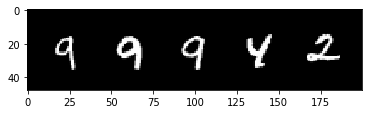

In [32]:
# Visualize some of the test images 
# and see their prediction

test_iterator = iter(testloader)
X_test, y_test = test_iterator.next()
X_test, y_test = X_test[:5], y_test[:5]
visualize_data(X_test)
model.eval()
with torch.no_grad():
    logits = model(X_test.cuda())
    prediction = pred(logits)
print("Prediction: ", prediction.tolist())